# Decanter AI Core SDK Jupyter Notebook Example
This example provides how to use the python package decanter-ai-core-sdk, including installation, usage of the apis, and some ways to show chart of the experiment's attributes and data values. 

## Installation

In [1]:
!pip install decanter-ai-core-sdk

## Running Example

In [2]:
import os
from decanter import core
from decanter.core.core_api import TrainInput, PredictInput, SetupInput
from decanter.core.enums.algorithms import Algo
from decanter.core.enums.evaluators import Evaluator

### Create Context
Create Context will set the connection to decanter core server, and create an event loop. Since Jupyter already have an event loop, SDK will just use the current event loop. See more in [here](https://www.notion.so/API-615d2fba4e7f45c4b5fe63cc192e481f#bb4f0a4b2847450abc4f80b025469170)

In Jupyter, it will initially exist a running event loop.

In [3]:
import asyncio
loop = asyncio.get_running_loop()
loop.is_running()

True

In [4]:
# enable default logger
core.enable_default_logger()

### Create Decanter Core Client
CoreClient handles the actions of calling api and getting the results.

In [2]:
# set the username, password, host
client = core.CoreClient(username='gp', password='gp-admin', host='http://localhost:3000')

Note: It is ok to recreate context to set the usr, pwd, host.

Example of using `core.upload`, `core.train`, `core.predict`.
While it's running, it'll show up the progress bar showing the progress of current running jobs.

In [6]:
# open train & test file
train_file_path = os.path.join('data/train.csv')
test_file_path = os.path.join('data/train.csv')
train_file = open(train_file_path , 'r')
test_file = open(test_file_path , 'r')

# upload data to corex 
train_data = client.upload(file=train_file, name="train_data", name='upload_train_data')
test_data = client.upload(file=test_file, name="test_data", name='upload_train_data')
# from decanter.core.jobs import DataUpload
# train_data = DataUpload.create(data_id = "{data_id}", name="train_data")

# Set up data to change data type.
setup_input = SetupInput(
        data = train_data,
        data_source=train_data.accessor,
        data_columns=[
            {
                'id': 'Pclass',
                'data_type': 'categorical'
            }]
        )

train_data = client.setup(setup_input)

# # set train parameters train model
train_input = TrainInput(data=train_data, target='Survived', algos=[Algo.XGBoost], max_model=2, tolerance=0.9)
exp = client.train(train_input=train_input, select_model_by=Evaluator.mean_per_class_error, name='myexp')

# # set predict parameters and predict result
predict_input = PredictInput(data=test_data, experiment=exp)
pred_res = client.predict(predict_input=predict_input, name='mypred')

In [3]:
# To prevent getting attributes when corresponding jobs aren't finished
exp.get(attr='attributes')
exp.best_model.get(attr='importances')
pred_res.get(attr='schema')

### Show Data
Use `data.show_df()` and `predict_result.show_df()` to create pandas dataframe. <br>
Use `data.show()` or `predict_result.show()` to show data in text.

In [11]:
train_data.show_df()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
708,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C
711,712,0,1,"Klaber, Mr. Herman",male,NaN,0,0,113028,26.5500,C124,S


### Show models attributes
List the attributes you wish to see in a list, and call `core.plot.show_model_attr(attrs, exp)`

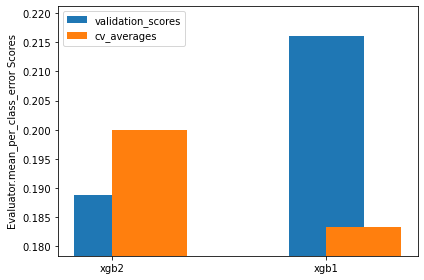

,name,id,validation_scores,cv_averages
0,xgb2,5f6ee6e9ad2c960001797675,0.188814,0.199864
1,xgb1,5f6ee6e9ad2c960001797677,0.216148,0.183373


In [12]:
core.plot.show_model_attr(metric=Evaluator.mean_per_class_error, score_types=['validation', 'cv_averages'], exp=exp)

### Get Data values with Data instance
Plot chart with the values in data instance

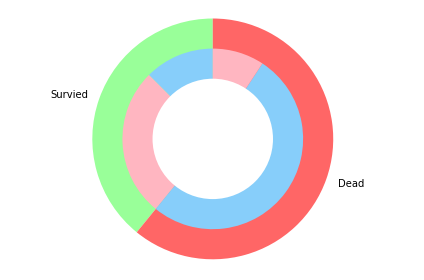

In [13]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Survied', 'Dead']
labels_gender = ['male', 'female', 'male', 'female']


df = train_data.show_df()
df_s = df.loc[df["Survived"] == 1]
df_d = df.loc[df["Survived"] == 0]

sizes = [df_s.shape[0], df_d.shape[0]]

sizes_gender = []
for d in [df_s, df_d]:
    s1 = d.loc[d["Sex"] == "male"].shape[0]
    s2 = d.loc[d["Sex"] == "female"].shape[0]
    sizes_gender.append(s1)
    sizes_gender.append(s2)

    
colors = ['#99ff99', '#ff6666']
colors_gender = ['#87CEFA','#FFB6C1', '#87CEFA','#FFB6C1']
 
# Plot
plt.pie(sizes, labels=labels, colors=colors, startangle=90,frame=True)
plt.pie(sizes_gender,colors=colors_gender ,radius=0.75,startangle=90)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()
plt.show()